In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deep_memory import *

In [18]:
import numba
import random
#simulate trajectory with single_exponential memory kernel
#particle confined in double well potential
from gle_single_exp import *


nsteps=1e6
dt=.01
kT=2.494
k=1; m=1; gamma=1; U0=1*kT; x0=0;
tau=gamma/k

v0=random.gauss(0.0,math.sqrt(kT/m))
y0=random.gauss(x0,math.sqrt(kT/gamma))

x,v,y=integrate_sing_exp(nsteps=nsteps, dt=dt, k=k, m=m, gamma=gamma,
U0=U0, x0=x0, v0=v0, y0=y0, kT=kT, scheme=1)

np.save("test_trj", x)

In [19]:
#loading simulated trajectory
x = np.load("test_trj.npy")

#given parameters of simulation
dt=.01
kT=2.494
k=1; m=1; gamma=1; U0=1*kT; x0=0;
tau=gamma/k

t = np.arange(0,len(x)*dt,dt)

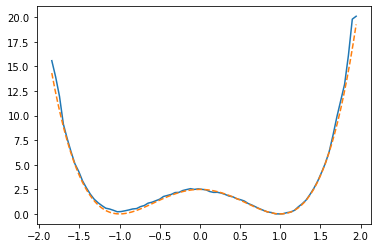

In [20]:
#checking free  energy of trajectory
hist,edges=np.histogram(x, bins=80, density=True)
pos=(edges[1:]+edges[:-1])/2

fe=-kT*np.log(hist); fe-=np.min(fe)

x2 = np.linspace(np.min(pos), np.max(pos), 100)
energy_real = U0 * ((x2)**2 - 1)**2

plt.plot(pos,fe)
plt.plot(x2,energy_real,'--')
plt.show()

In [21]:
#calculating xva_frame and correlation functions
xf=xframe(x,t,fix_time=True)
xvaf=compute_va(xf,correct_jumps=True)

x = xvaf["x"]
v = xvaf["v"]
a = xvaf['a']

corrv=correlation(v)
corrva = correlation(v,a)
corra = correlation(a)

m = kT/corrv[0]

force=4*U0*(x**3-x)/m
corrxu=correlation(force,x)
corrvu=correlation(force,v)
corrau=correlation(force,a)

(1000, 1) (1000, 1)


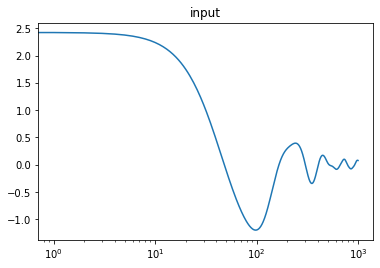

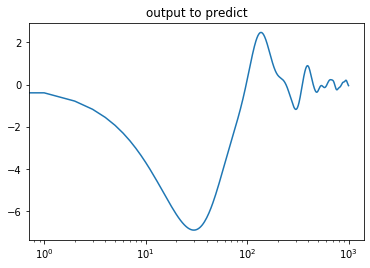

In [22]:
#deep memory kernel extraction with Multi-Layer-Perceptron

trunc = 1000
X = corrv[:trunc]

#y = np.gradient(x)
y = corrva[:trunc] * m

fe = corrvu[:trunc]

X = np.array([X]).T
y = np.array([y]).T
print(X.shape, y.shape)

plt.plot(X)
plt.xscale('log')
plt.title('input')
plt.show()

plt.plot(y)
plt.xscale('log')
plt.title('output to predict')
plt.show()


In [39]:
#fitting MLP (with given initial value of memory kernel)

model = MultilayerPerceptron(n_hidden=1,
    n_iterations=100,
    learning_rate=0.01, dt = 0.01, optimizer = 'adam', fe = fe)


initial = ((m*corra[0] - corrau[0])/corrv[0])

V, v0, W, w0 = model.fit(X, y,early_stop = 4e-06, accept_bias = False, check_loss = 3, initial = True)

loss in epoch 1 : 0.0029018358892909874
loss in epoch 2 : 0.0029192532732313188
loss in epoch 3 : 0.002943464203841715
loss in epoch 4 : 0.002972804486431894
loss in epoch 5 : 0.0030064318726369613
loss in epoch 6 : 0.002934187912953753
loss in epoch 7 : 0.0029697834246016834
loss in epoch 8 : 0.003008351262030248
loss in epoch 9 : 0.0029375327929121505
loss in epoch 10 : 0.002975813483297534
loss in epoch 11 : 0.002938383356206978
loss in epoch 12 : 0.002977244117277484
loss in epoch 13 : 0.002938612551714762
loss in epoch 14 : 0.0029774932358739036
loss in epoch 15 : 0.002938440706157668
loss in epoch 16 : 0.002976978280527448
loss in epoch 17 : 0.0029380094557385997
loss in epoch 18 : 0.00297597080751764
loss in epoch 19 : 0.00293741305610004
loss in epoch 20 : 0.0029746527467133296
loss in epoch 21 : 0.002936715526388413
loss in epoch 22 : 0.0029731480510328174
loss in epoch 23 : 0.002935960828766248
loss in epoch 24 : 0.0029715418681966646
loss in epoch 25 : 0.0029351792642187398


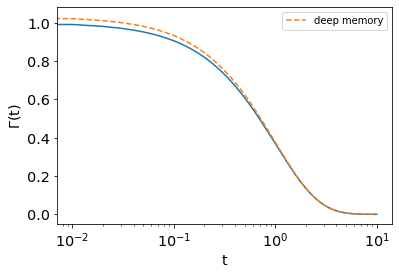

In [40]:
kernel_index = np.arange(0,trunc*dt,0.01)
kernel_real = gamma/tau*np.exp(-kernel_index/tau)

kernel_deep = model.compute_kernel(kernel_index)

plt.plot(kernel_index, kernel_real)
plt.plot(kernel_index,kernel_deep, '--',label = 'deep memory')

plt.xscale('log')
plt.ylabel(r'$\Gamma$(t)', fontsize = 'x-large')
plt.xlabel('t', fontsize = 'x-large')
plt.xticks(fontsize = 'x-large')
plt.yticks(fontsize = 'x-large')
plt.legend()
plt.show()

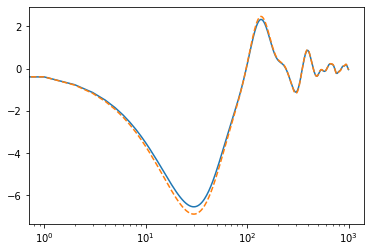

In [41]:
pred = model.predict(X)
plt.plot(pred)
plt.plot(y, '--')
plt.xscale('log')